In [1]:
import torch
import fastai.vision.all as vision
from fastai.callback.tensorboard import TensorBoardCallback
import os
import pandas as pd
import warnings
import numpy as np
import random
from glob import glob
import shutil
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('../data/02/fer_2013_2.feather')
df.shape

(35834, 6)

In [3]:
idx = []
for cls in df.target.unique():
    idx += list(df[df.target == cls].sample(500).index)

In [4]:
sample_df = df[df.index.isin(idx)]
sample_df = sample_df[["file", "target"]]
sample_df.target.value_counts()

fear        500
neutral     500
sad         500
angry       500
disgust     500
happy       500
surprise    500
Name: target, dtype: int64

In [5]:
sample_df

,file,target
1,../data/01/fer_2013/fear/Training_65828754.jpg,fear
9,../data/01/fer_2013/fear/Training_35929758.jpg,fear
10,../data/01/fer_2013/fear/Training_23028959.jpg,fear
11,../data/01/fer_2013/fear/PrivateTest_62337547.jpg,fear
16,../data/01/fer_2013/fear/Training_50791836.jpg,fear
...,...,...
35786,../data/01/fer_2013/surprise/PrivateTest_81021004.jpg,surprise
35793,../data/01/fer_2013/surprise/Training_91481863.jpg,surprise
35801,../data/01/fer_2013/surprise/Training_29584262.jpg,surprise
35805,../data/01/fer_2013/surprise/Training_89923105.jpg,surprise


In [6]:
import sklearn.metrics as skm
class CCI(vision.ClassificationInterpretation):
    def classification_report_dataframe(self)  -> pd.DataFrame:
        """return classification report as Dataframe.

        This function is a copy of the
        fastai.vision.ClassificationInterpretation.print_classification_report(),
        returning classification report instead of printing it.

        Returns:
            pd.DataFrame: classification report
        """
        _, targs, decoded = self.learn.get_preds(
            dl=self.dl,
            with_decoded=True,
            with_preds=True,
            with_targs=True,
            act=self.act
        )
        d, t = vision.flatten_check(decoded, targs)
        names = [str(v) for v in self.vocab]
        cf = skm.classification_report(
            t, d,
            labels=list(self.vocab.o2i.values()),
            target_names=names,
            output_dict=True
        )
        return pd.DataFrame(cf).applymap(lambda x: round(x, 4))


In [7]:
data_aug = vision.aug_transforms(
        mult=3,
        max_rotate=15,
        min_zoom=0.9,
        max_zoom=1.1,
        size=48, 
        max_lighting=.1,
        max_warp=.1, 
    )

In [8]:
def random_seed(seed_value, use_cuda):
    '''Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.'''
    np.random.seed(seed_value) # Numpy vars
    torch.manual_seed(seed_value) # PyTorch vars
    random.seed(seed_value) # Python
    if use_cuda: # GPU vars
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False
    print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

seed = 111
random_seed(seed, True)

Random state set:111, cuda used: True


In [9]:
bs = 16
dls = vision.ImageDataLoaders.from_df(
    df=sample_df,
    valid_pct=.2,
    bs=bs,
    shuffle=True,
    device=torch.device('cuda'),
    # batch_tfms=data_aug
)

In [10]:
arch = vision.models.vgg13_bn
name = arch.__name__
path = os.path.join('../models/logs/fastai/vgg_13_1.0', str(bs), name)
if not os.path.exists(path):
    os.makedirs(path)
callbacks = [
    vision.EarlyStoppingCallback(patience=5),
    vision.ReduceLROnPlateau(patience=2, factor=10),
    TensorBoardCallback(path),
]
print(f'{name.capitalize()}\nBatch size : {bs}')
learner_path = '../models/fastai/vgg_13_1.0'
if not os.path.exists(learner_path):
    os.makedirs(learner_path)
learner_name = f'{learner_path}/{name}_{bs}'

learn = vision.vision_learner(
    dls=dls, 
    arch=arch, 
    metrics=vision.F1Score(average='macro'),
    cbs=callbacks,
    path=learner_path,
    # weigth decay inside the epoch
    wd=1e-6,
    # learning_rate
    lr=1e-7
)

learn.fine_tune(200)

Vgg13_bn
Batch size : 16


epoch,train_loss,valid_loss,f1_score,time
0,2.856420,2.601677,0.218090,00:54


epoch,train_loss,valid_loss,f1_score,time
0,2.479683,2.288049,0.274253,01:29
1,2.320320,2.138360,0.289298,01:31
2,2.231271,1.985732,0.302698,01:34
3,2.100035,1.934935,0.303461,01:30
4,2.007243,1.856331,0.323595,01:33
5,1.994619,1.851334,0.338504,01:30
6,1.887170,1.818864,0.343181,01:30
7,1.920859,1.799940,0.350897,01:31
8,1.847835,1.748461,0.351526,01:30
9,1.812265,1.678193,0.384517,01:26


Epoch 23: reducing lr to 4.762793806274546e-05
Epoch 29: reducing lr to 5.998802701048429e-05
Epoch 31: reducing lr to 6.416923069486313e-05
No improvement since epoch 27: early stopping


In [11]:
cci = CCI.from_learner(learn)

cr = cci.classification_report_dataframe().T

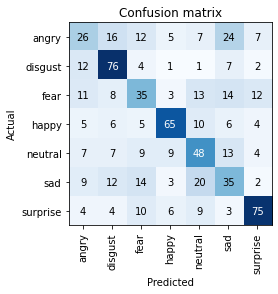

In [12]:
cci.plot_confusion_matrix()

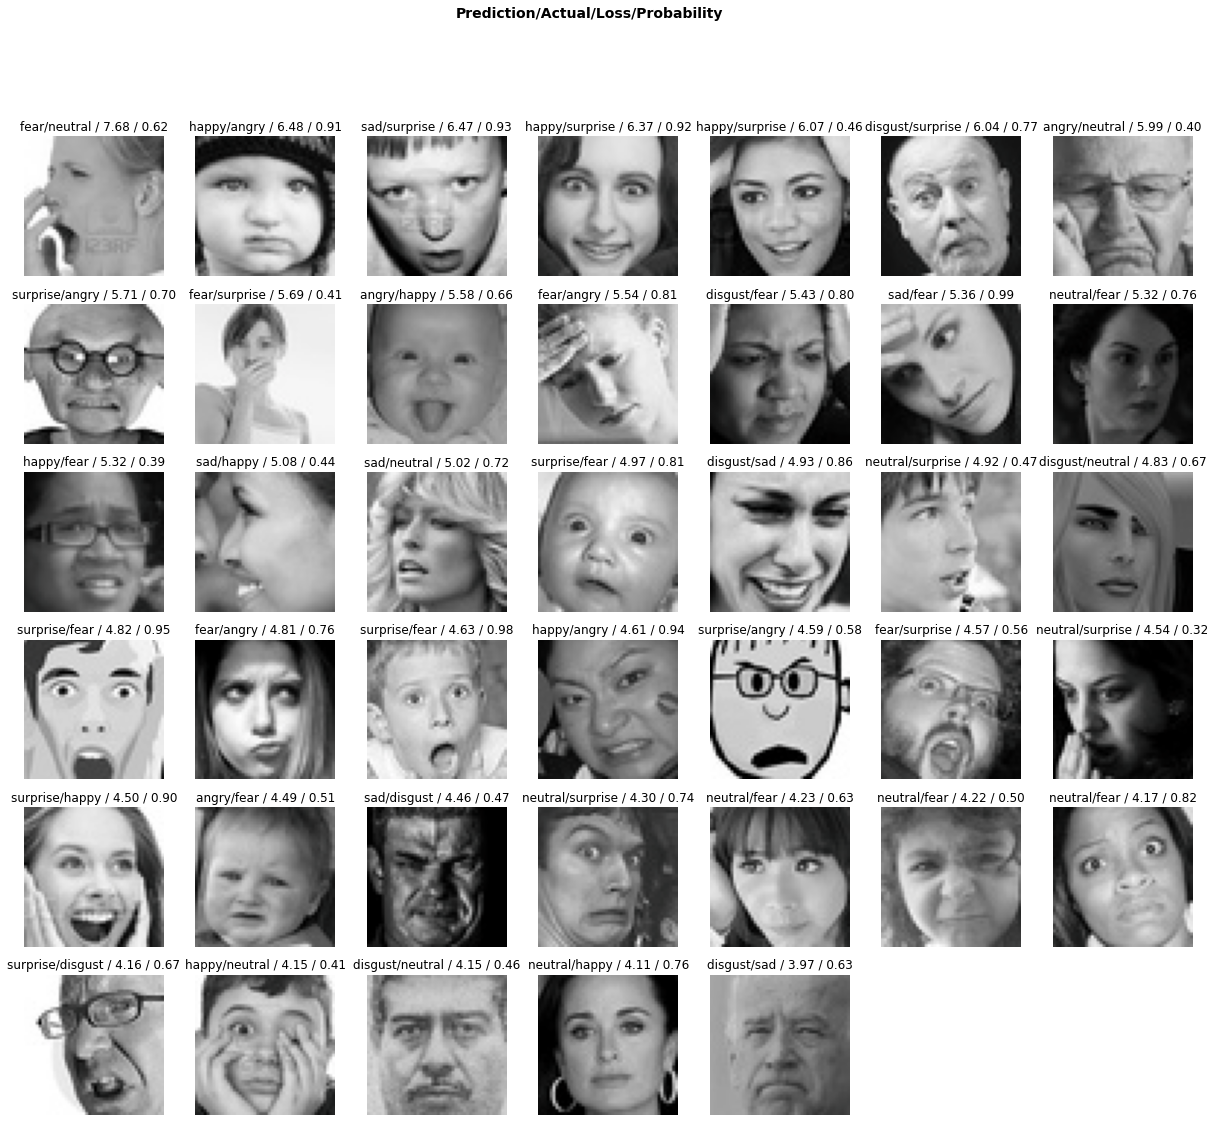

In [13]:
n = 40
cci.plot_top_losses(n)

In [14]:
top_losses = cci.top_losses(items=True)[-1]

In [15]:
from fastai.vision.all import *
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner.set_fns(top_losses.file.values.tolist())
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'file'

In [ ]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()